## Conditional Variational Autoencoder with PyTorch

In [1]:
import torch
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm
import os

# os.chdir(os.path.dirname(__file__))

# Building the model

## Onehot function

Compared with VAE, CVAE contains the step of onehot encoding. We convert the numbers 0-9 into ten-dimensional vectors, e.g. number "2" is converted to $[0,0,1,0,0,0,0,0,0,0]$ with a number "1" in the 2nd index. 

The reason of doing this is to turn the ten numbers into orthogonal vectors, so that they are linearly independent.

In [2]:
def onehot(x, max_dim):
    # x: list of labels for the input images
    # max_dim: number of possible classes (the size of onehot vector)
    batch_size = x.shape[0] # number of samples in the batch
    vector = torch.zeros(batch_size, max_dim).to(x.device) # to(x.device) ensures the onehot vector tensor 
                                                           # is on the same device (CPU/GPU) as x
    for i in range(batch_size):
        vector[i,x[i]] = 1
    return vector

## Model structure

In [3]:
class Encoder(torch.nn.Module):
    #encoder, compress data with input_size dimensions to mu and sigma with latent_size dimensions
    def __init__(self, input_size, hidden_size, latent_size):
        super(Encoder, self).__init__()
        self.linear = torch.nn.Linear(input_size, hidden_size)
        self.mu = torch.nn.Linear(hidden_size, latent_size)
        self.sigma = torch.nn.Linear(hidden_size, latent_size)
        
    def forward(self, x):# x: bs,input_size
        x = F.relu(self.linear(x)) #-> bs,hidden_size
        mu = self.mu(x) #-> bs,latent_size
        sigma = self.sigma(x)#-> bs,latent_size
        return mu,sigma

class Decoder(torch.nn.Module):
    #decoder，convert data with latent_size dimensions to data with output_size dimensions
    def __init__(self, latent_size, hidden_size, output_size):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(latent_size, hidden_size)
        self.linear2 = torch.nn.Linear(hidden_size, output_size)
        
    def forward(self, x): # x:bs,latent_size
        x = F.relu(self.linear1(x)) #->bs,hidden_size
        x = torch.sigmoid(self.linear2(x)) #->bs,output_size
        return x

class CVAE(torch.nn.Module):
    #combine encoder and decoder
    def __init__(self, input_size, output_size, condition_size,
                 latent_size, hidden_size):
        super(CVAE, self).__init__()
        self.encoder = Encoder(input_size + condition_size, 
                               hidden_size, latent_size)
        self.decoder = Decoder(latent_size + condition_size, 
                               hidden_size, output_size)
        
    def forward(self, x, c): #x: bs,input_size|c:bs, condition_size
        x = torch.cat((x,c),dim = 1) # Concatenate input and condition
        mu, sigma = self.encoder(x) # mu,sigma: bs,latent_size
        
        # Sample from standard normal distribution
        eps = torch.randn_like(sigma)  #eps: bs,latent_size
        # Reparameterization trick to sample z
        z = mu + eps * sigma  #z: bs,latent_size
        # Concatenate z with condition
        z = torch.cat((z,c),dim = 1) #z: bs,latent_size + condition_size
        # Reconstruct data using decoder
        recon_x = self.decoder(z) # re_x: bs,output_size
        return recon_x, mu, sigma

## Loss function

In [4]:
loss_BCE = torch.nn.BCELoss(reduction = 'sum')
loss_MSE = torch.nn.MSELoss(reduction = 'sum')
loss_KLD = lambda mu,sigma: -0.5 * torch.sum(1 + torch.log(sigma**2) - mu.pow(2) - sigma**2)

# Hyperparameters and model construction

## Model parameters

In [5]:
latent_size =16 # latent space dimension
hidden_size = 128 # hidden layer dimension
input_size = output_size = 28 * 28 
condition_size = 10 

## Training parameters

In [6]:
epochs = 5 
batch_size = 32 
learning_rate = 3e-3 
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model construction

In [7]:
modelname = 'cvae.pth'
model = CVAE(input_size, output_size, condition_size, latent_size,hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
try:
    model.load_state_dict(torch.load(modelname))
    print('[INFO] Load Model complete')
except:
    pass

[INFO] Load Model complete


/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_37046/2882787115.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(modelname))


# Model training and visualisation

## Prepare for MNIST dataset

In [8]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                    transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=False)

## Model training

[train]epoch:0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:08<00:00, 226.08it/s]


epoch:0|TrainLoss:  154.89797618815103


[eval]epoch:0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 407.55it/s]


epoch:0|Test Loss:  152.3892573730469


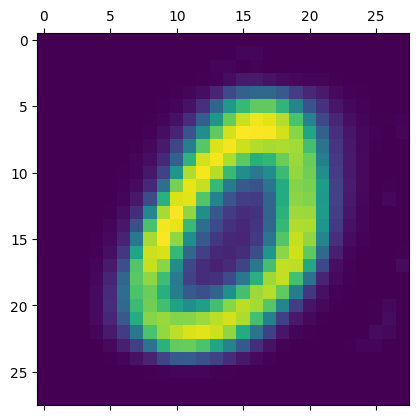

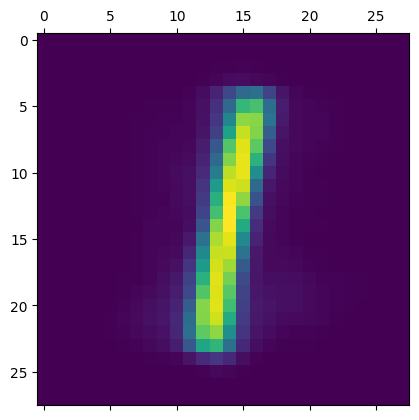

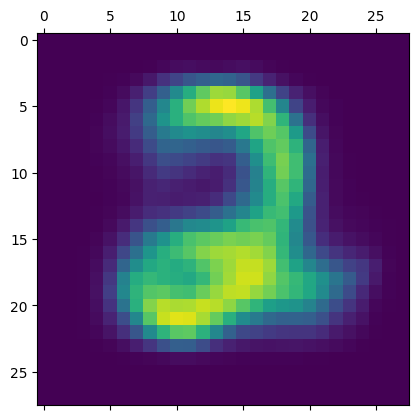

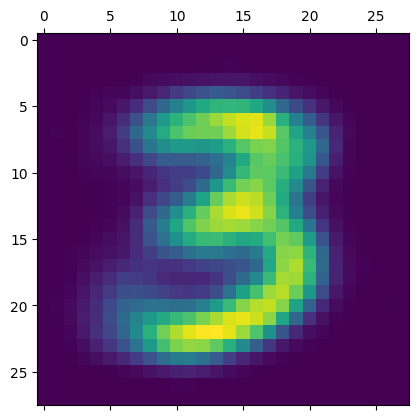

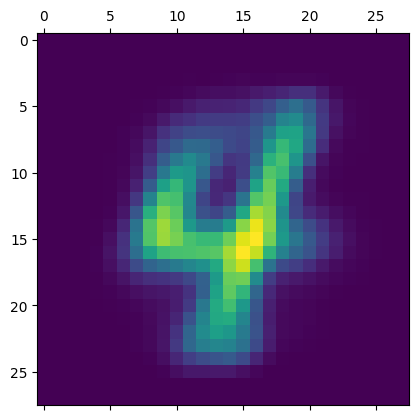

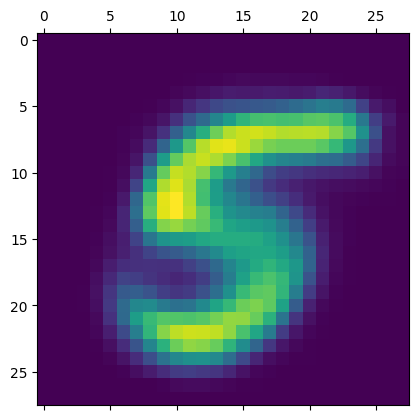

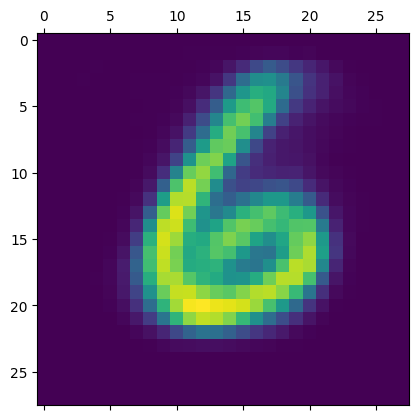

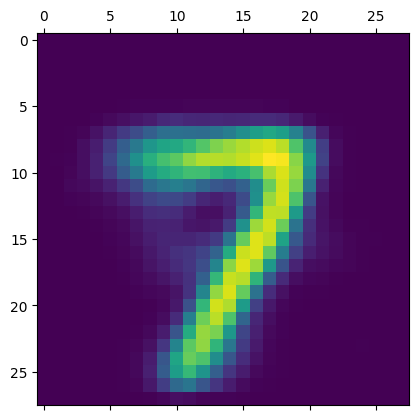

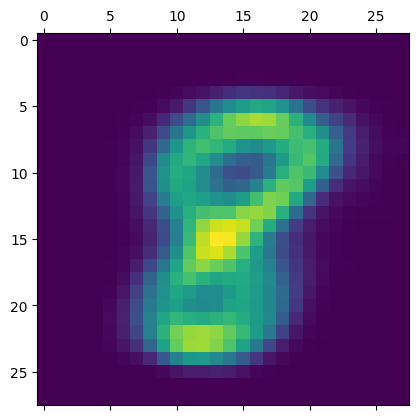

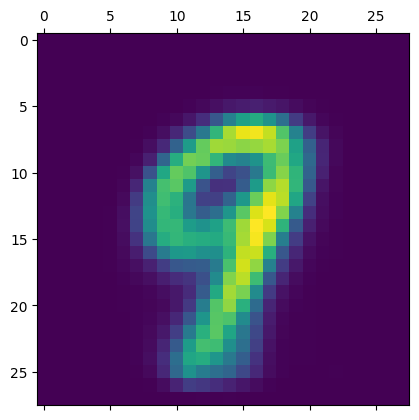

[train]epoch:1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:09<00:00, 205.54it/s]


epoch:1|TrainLoss:  153.6326319580078


[eval]epoch:1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 393.89it/s]


epoch:1|Test Loss:  153.733690625


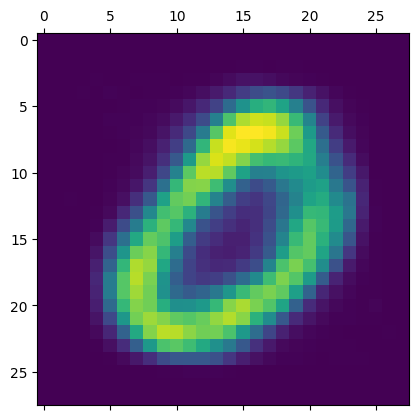

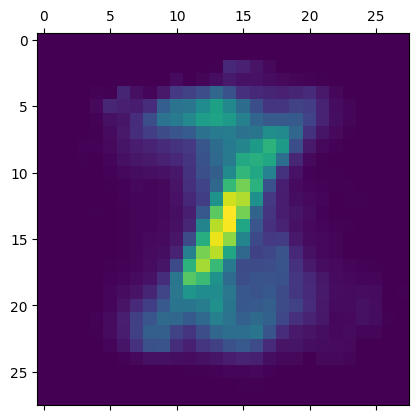

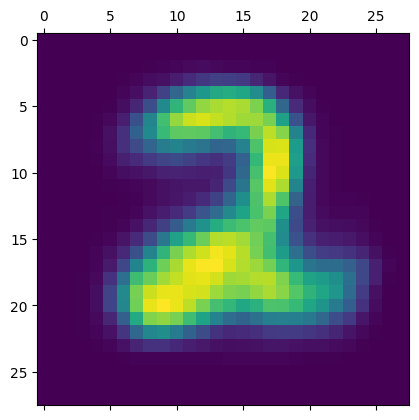

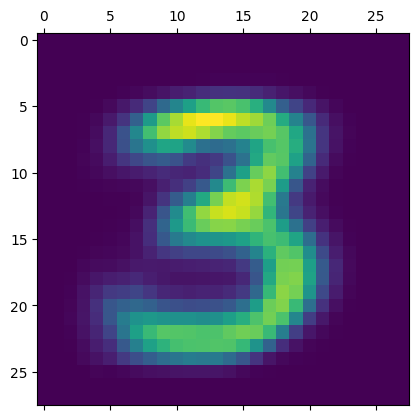

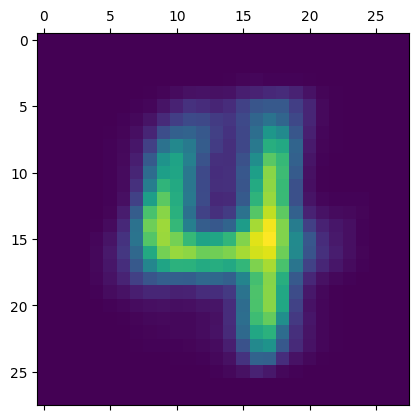

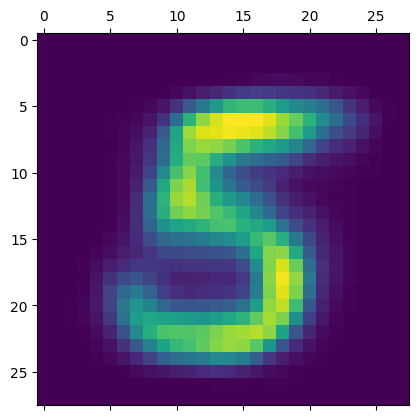

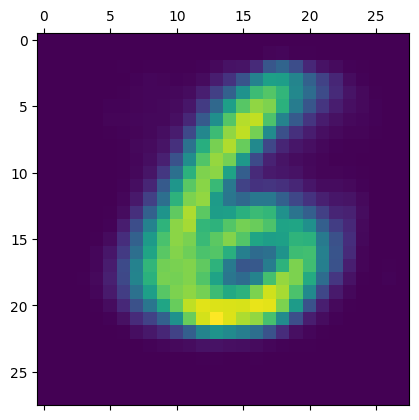

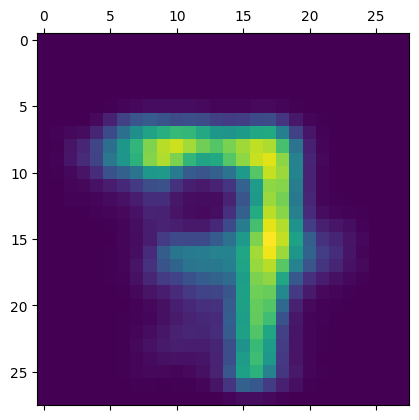

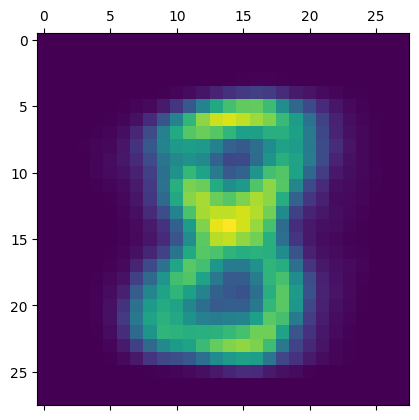

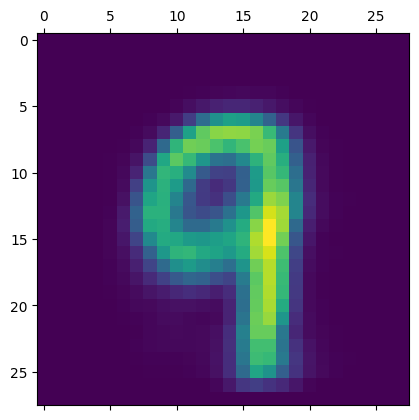

[train]epoch:2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:08<00:00, 220.54it/s]


epoch:2|TrainLoss:  153.5197988972982


[eval]epoch:2: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 399.32it/s]


epoch:2|Test Loss:  149.91633500976562


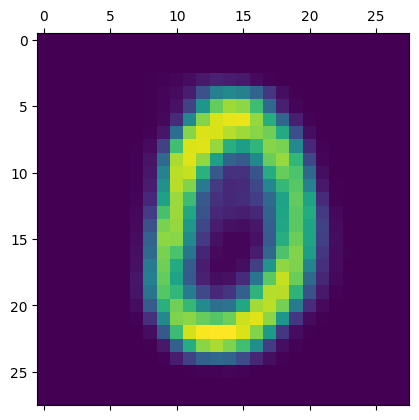

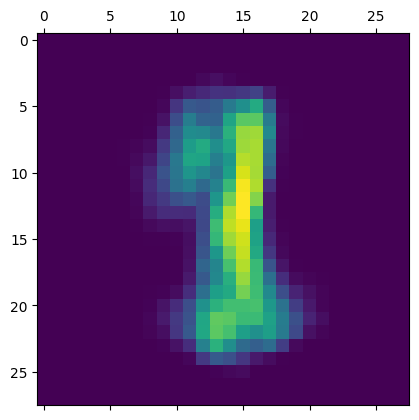

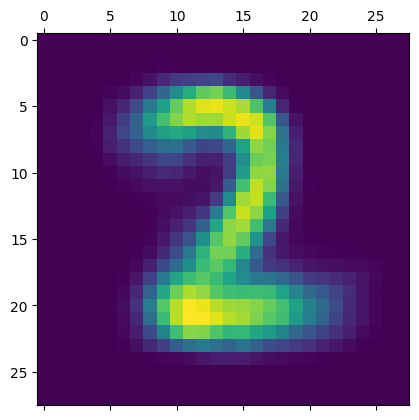

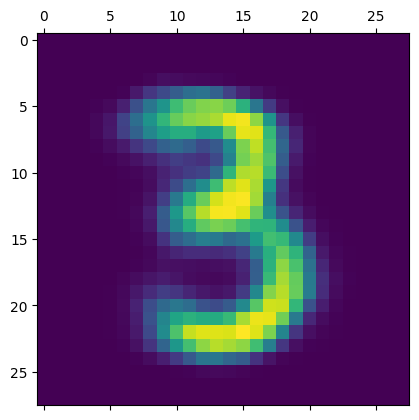

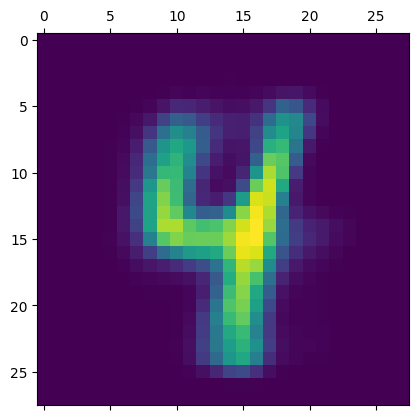

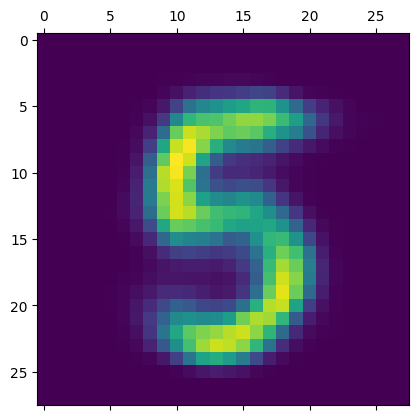

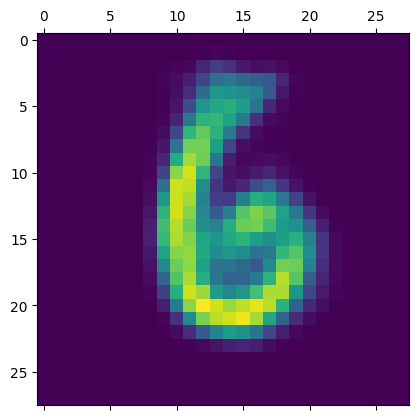

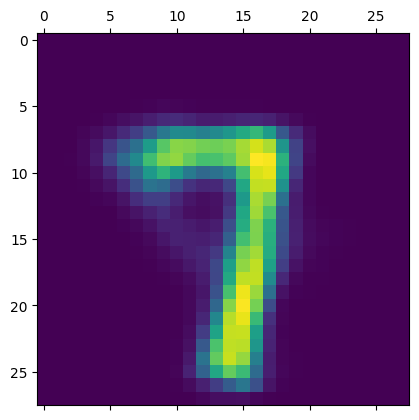

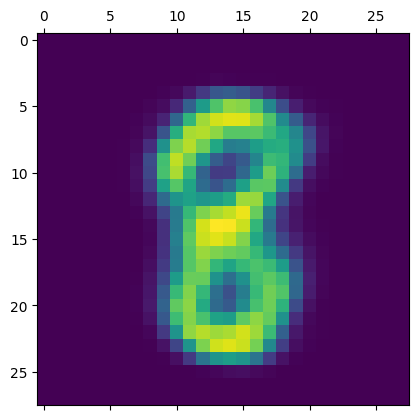

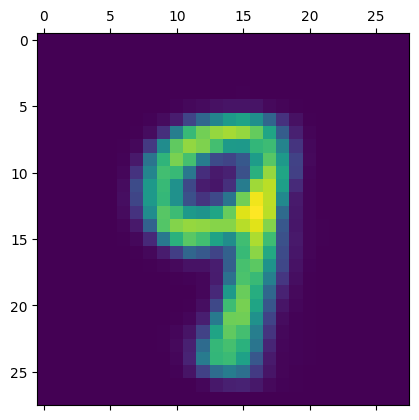

[train]epoch:3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:08<00:00, 220.84it/s]


epoch:3|TrainLoss:  149.54481699625651


[eval]epoch:3: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:01<00:00, 247.44it/s]


epoch:3|Test Loss:  148.73004194335937


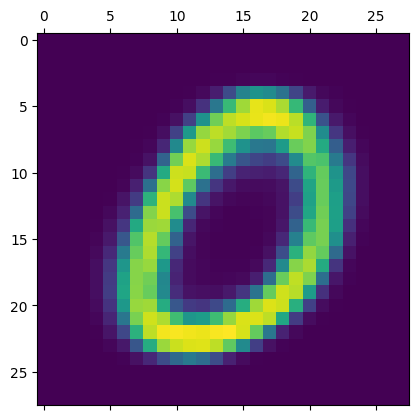

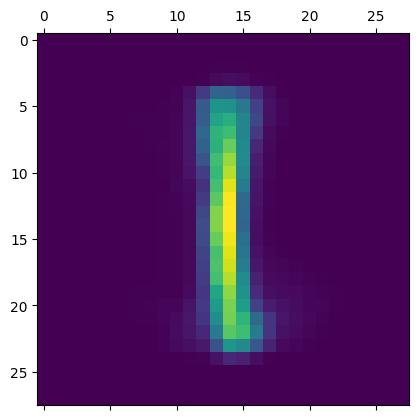

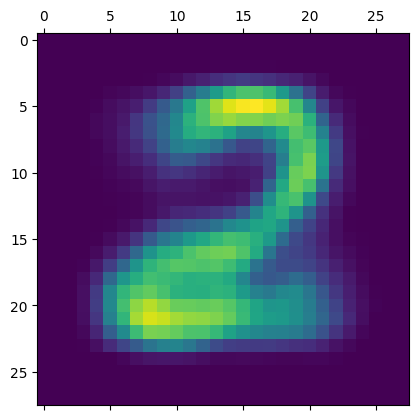

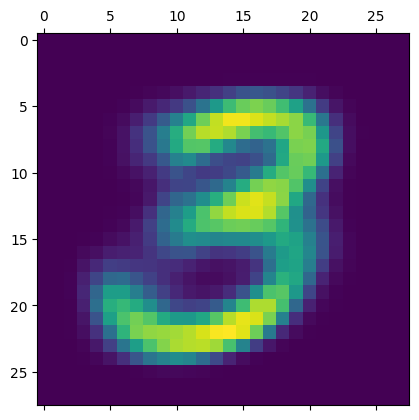

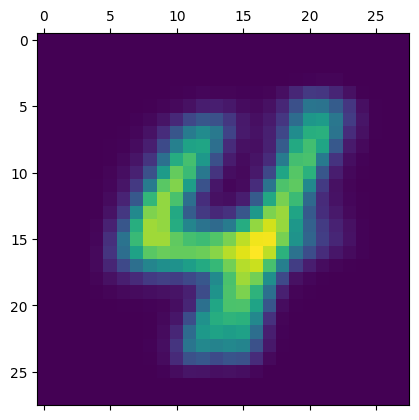

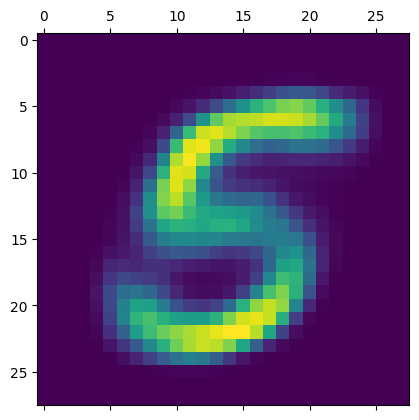

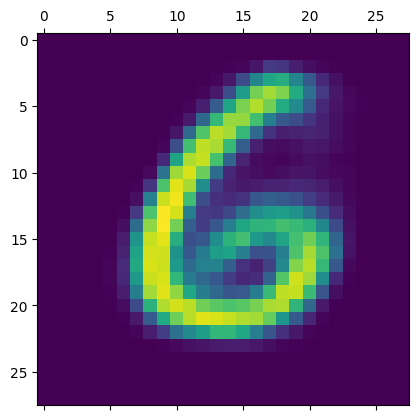

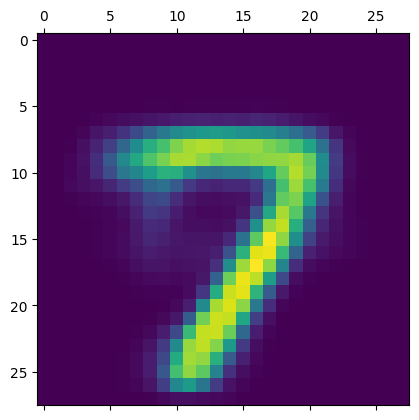

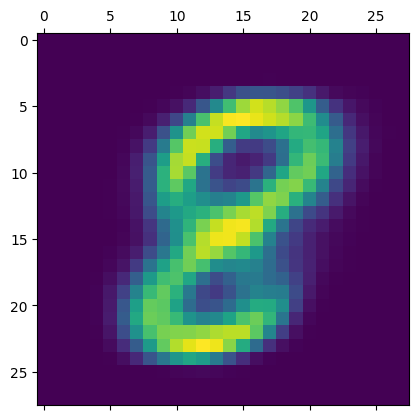

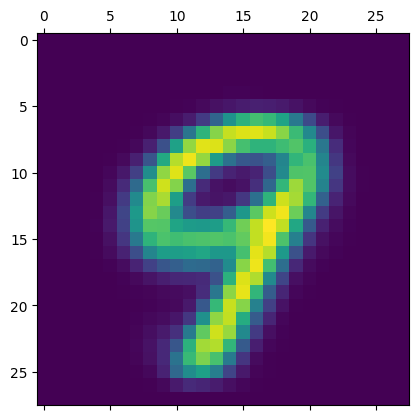

[train]epoch:4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:08<00:00, 209.51it/s]


epoch:4|TrainLoss:  150.3120530924479


[eval]epoch:4: 100%|████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:00<00:00, 359.22it/s]


epoch:4|Test Loss:  150.13177817382814


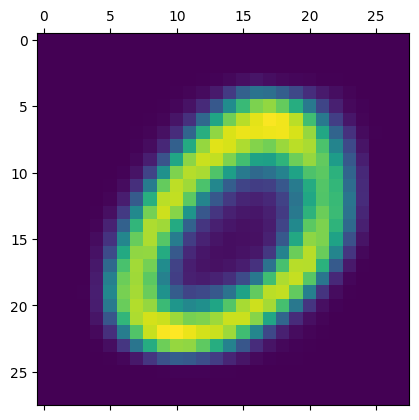

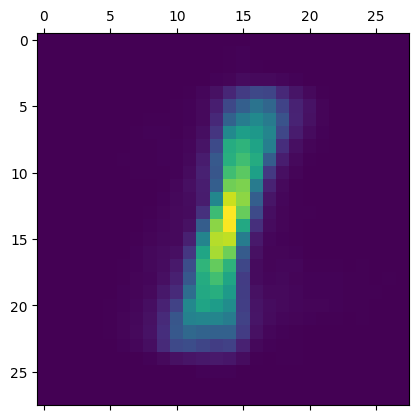

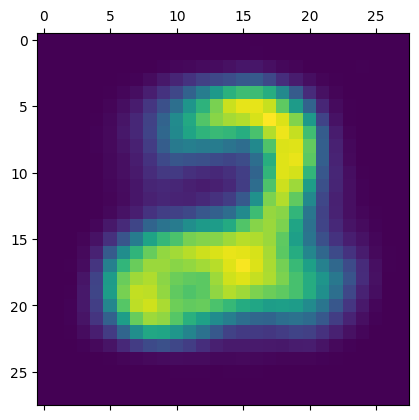

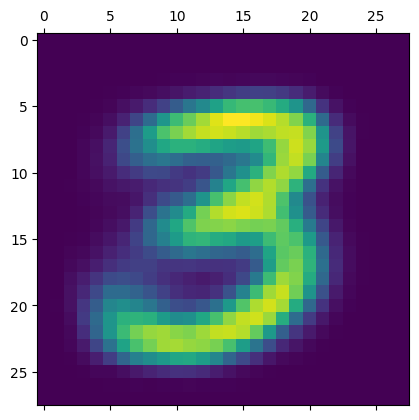

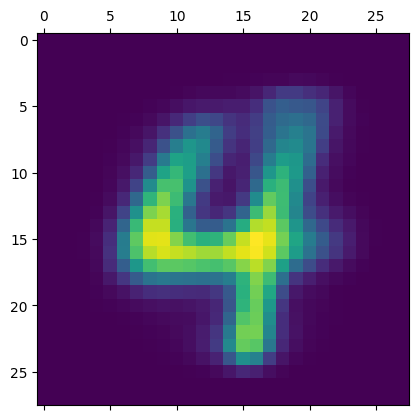

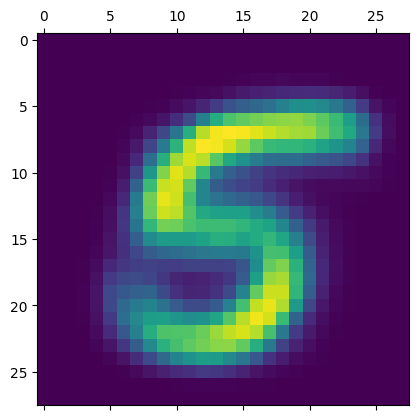

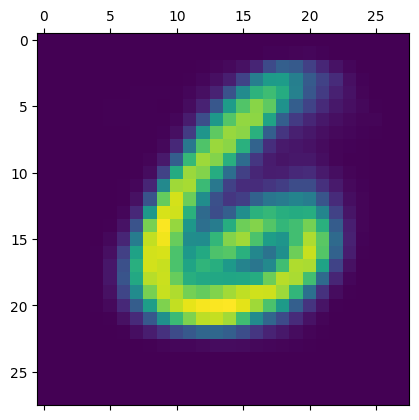

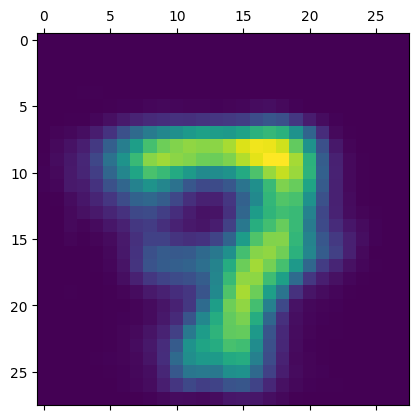

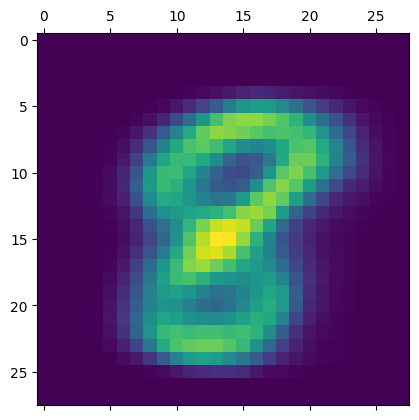

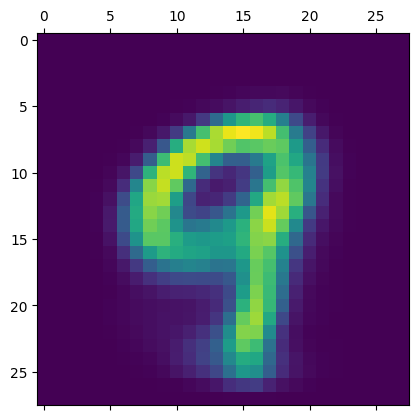

In [50]:
for epoch in range(epochs):   
    '''model training'''
    #reset loss for each epoch    
    train_loss = 0
    #get data
    for imgs, lbls in tqdm(train_loader,desc = f'[train]epoch:{epoch}'): #img: (batch_size,1,28,28)| lbls: (batch_size,)
        bs = imgs.shape[0]    
        imgs = imgs.view(bs,input_size).to(device) #batch_size,input_size(28*28)
        
        # print(f"input of onehot function: {lbls.to(device)}")
        lbls = onehot(lbls.to(device),condition_size)
        # print(f"output of onehot function: {lbls}")
        
        re_imgs,mu,sigma = model(imgs,lbls)
        
        #calculate loss
        loss_re = loss_BCE(re_imgs, imgs) 
        loss_norm = loss_KLD(mu, sigma) 
        loss = loss_re + loss_norm  
        
        #backpropagation, optimise parameters
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #record total loss
        train_loss += loss.item()
    #print average loss
    print(f'epoch:{epoch}|Train Loss: ',train_loss/len(train_loader.dataset))

    
    # evaluate the model
    model.eval()
    #reset loss for every epoch    
    test_loss = 0
    #get data
    for imgs, lbls in tqdm(test_loader,desc = f'[eval]epoch:{epoch}'):#img: (batch_size,28,28)| lbls: (batch_size,)
        bs = imgs.shape[0]
        imgs = imgs.view(bs,input_size).to(device) #batch_size,input_size(28*28)
        lbls = onehot(lbls.to(device),condition_size)
        
        re_imgs,mu,sigma = model(imgs,lbls)
        #calculate loss
        loss_re = loss_BCE(re_imgs, imgs) 
        loss_norm = loss_KLD(mu, sigma) 
        loss = loss_re + loss_norm    
        #record total loss
        test_loss += loss.item()
    #print average loss
    print(f'epoch:{epoch}|Test Loss: ',test_loss/len(test_loader.dataset))
    model.train()


    model.eval()
    #sample data from normal distribution
    sample = torch.randn(1,latent_size).to(device)

    #visualisation
    for i in range(condition_size):
        #generate new data with decoder
        i_number = i*torch.ones(1).long().to(device)
        condit = onehot(i_number,condition_size)
        inputs = torch.cat((sample,condit),dim = 1)
        gen = model.decoder(inputs)[0].view(28,28)
        plt.matshow(gen.cpu().detach().numpy())
        plt.show()
    model.train()


    # save the model
    torch.save(model.state_dict(), modelname)

## Visualisation

/var/folders/zx/j5d_p2_s2wz05zg3b78717100000gn/T/ipykernel_37046/3591525622.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('cvae.pth', 

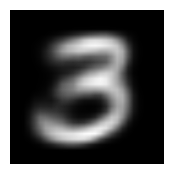

In [11]:
'''Model prediction''' # use trained model or saved trained model to predict

# Load the model weights from 'cvae.pth'
model.load_state_dict(torch.load('cvae.pth', map_location=device))
model.eval()  # Set the model to evaluation mode

# Generate a sample from the latent space
sample = torch.randn(1, latent_size).to(device)

i = 3
i_number = i * torch.ones(1).long().to(device) 
condit = onehot(i_number, condition_size)  # One-hot encoding of the label
inputs = torch.cat((sample, condit), dim=1)  # Concatenate latent sample and condition

# Use the decoder to generate the new image
with torch.no_grad():  # Disable gradient computation for memory efficiency and faster inference
    gen = model.decoder(inputs)[0].view(28, 28)  # Generate output and reshape

plt.imshow(gen.cpu().detach().numpy(), cmap='gray', interpolation='bilinear')
plt.gcf().set_size_inches(2, 2)  # Set display size in inches
plt.axis('off')
plt.show()


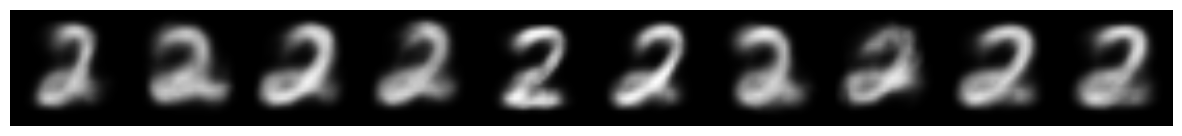

In [15]:
i = 2  # the digit we want to generate
i_number = i * torch.ones(10).long().to(device)  # Create a batch of 10, each labeled "2"
condit = onehot(i_number, condition_size)  # One-hot encoding of each label

# Sample latent space vectors for each image
samples = torch.randn(10, latent_size).to(device)  # 10 latent vectors
inputs = torch.cat((samples, condit), dim=1)  # Concatenate latent vector and label

# Generate images with the decoder
with torch.no_grad():
    gen_images = model.decoder(inputs).view(-1, 28, 28)  # Output shape: (10, 28, 28)

# Concatenate all images horizontally
gen_combined = torch.cat([img for img in gen_images], dim=1)  # Shape: (28, 280)

# Plot the combined image
plt.figure(figsize=(15, 5))
plt.imshow(gen_combined.cpu().detach().numpy(), cmap='gray', interpolation='bilinear')
plt.axis('off')
plt.show()
